In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
from livecell_tracker import segment
from livecell_tracker import core
from livecell_tracker.core import datasets
from livecell_tracker.core.datasets import LiveCellImageDataset
from skimage import measure
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic
import detectron2
from detectron2.utils.logger import setup_logger
import tqdm
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from livecell_tracker.segment.detectron_utils import gen_cfg

from livecell_tracker.segment.detectron_utils import (
    segment_detectron_wrapper,
    segment_images_by_detectron,
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)


dataset_dir_path = Path(
    "../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY9"
)

mask_dataset_path = Path("../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY9/seg")

In [2]:
def get_time_from_path(path):
    """example path: STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T287_XY09_TRITC.tif"""
    idx = 0
    strs = path.split("_")
    while idx < len(strs) - 1:
        if strs[idx][:2] == "XY":
            break
        idx += 1
    idx -= 1
    return int(strs[idx][1:])
get_time_from_path("example path: STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T287_XY09_DIC.tif")

287

In [3]:
MAX_IMG_NUM = 10

In [4]:
mask_time2url = {}
mask_paths = sorted(glob.glob(str(mask_dataset_path / "*.png")))[:MAX_IMG_NUM]
for mask_path in mask_paths:
    mask_time2url[get_time_from_path(mask_path)] = mask_path
label_mask_dataset = LiveCellImageDataset(ext="png", time2url=mask_time2url)
len(label_mask_dataset)

10

In [5]:

time2url = {}
img_paths = sorted(glob.glob(str(dataset_dir_path / "*_DIC.tif")))[:MAX_IMG_NUM]

for img_path in img_paths:
    time = get_time_from_path(img_path)
    time2url[time] = img_path

dic_dataset = LiveCellImageDataset(dataset_dir_path, time2url=time2url, ext="tif")

In [6]:
list(dic_dataset.time2url.items())[:5]

[(1,
  '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY9/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T001_XY09_DIC.tif'),
 (2,
  '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY9/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T002_XY09_DIC.tif'),
 (3,
  '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY9/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T003_XY09_DIC.tif'),
 (4,
  '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY9/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T004_XY09_DIC.tif'),
 (5,
  '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY9/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T005_XY09_DIC.tif')]

In [7]:
len(dic_dataset.time2url)

10

check co-existence of times

In [8]:
for time in label_mask_dataset.time2url:
    assert time in dic_dataset.time2url

for time in dic_dataset.time2url:
    assert time in label_mask_dataset.time2url

Convert label masks to single objects

In [9]:
from multiprocessing import Pool
from skimage.measure import regionprops


def process_mask(mask_dataset, dic_dataset, time):
    seg_mask = mask_dataset.get_img_by_time(time)
    props_list = regionprops(seg_mask)
    _scs = []
    for prop in props_list:
        _scs.append(
            SingleCellStatic(
                timeframe=time,
                img_dataset = dic_dataset,
                mask_dataset = mask_dataset,
                bbox=prop.bbox,
                contour=prop.coords,
            )
        )
    return _scs

def process_mask_wrapper(args):
    return process_mask(*args)

def prep_scs_from_mask_dataset(mask_dataset, dic_dataset, cores=None):
    scs = []

    inputs = [(mask_dataset, dic_dataset, time) for time in mask_dataset.time2url.keys()]
    pool = Pool(processes=cores)
    for _scs in tqdm.tqdm(pool.imap_unordered(process_mask_wrapper, inputs), total=len(inputs)):
        scs.extend(_scs)
    pool.close()
    pool.join()
    return scs

single_cells = prep_scs_from_mask_dataset(label_mask_dataset, dic_dataset, cores=None)

100%|██████████| 10/10 [00:00<00:00, 91.57it/s]


In [10]:
# from skimage.measure import regionprops
# single_cells = []

# for time in tqdm.tqdm(mask_dataset.time2url):
#     img = dic_dataset.get_img_by_time(time)
#     seg_mask = mask_dataset.get_img_by_time(time)
#     props_list = regionprops(seg_mask)
#     for prop in props_list:
#         single_cells.append(
#             SingleCellStatic(
#                 timeframe=time,
#                 img_dataset = dic_dataset,
#                 mask_dataset = mask_dataset,
#                 bbox=prop.bbox,
#                 contour=prop.coords,
#             )
#         )


check the number of single cells 

In [11]:
len(single_cells)

236

In [12]:
from functools import partial
def wrap_func(func, args):
    return func(*args)

def parallelize(func, inputs, cores=None):
    pool = Pool(processes=cores)
    outputs = []
    for output in tqdm.tqdm(pool.imap_unordered(partial(wrap_func, func), inputs), total=len(inputs)):
        outputs.append(output)
    pool.close()
    pool.join()
    return outputs

In [13]:
def set_sc_label(sc, bg_val=0):
    """Assume sc.mask_dataset contains label masks"""
    label_mask_pixels = sc.mask_dataset.get_img_by_time(sc.timeframe)[sc.bbox[0]:sc.bbox[2], sc.bbox[1]:sc.bbox[3]][sc.get_contour_mask()]
    labels = np.unique(label_mask_pixels)
    labels = list(set(labels))
    if bg_val in labels:
        labels.remove(bg_val) # remove bg label

    # TODO: figure out why skimage regionprops sometimes returns contours containing other labels...
    # it should be a bug in skimage
    if len(labels) != 1:
        label_info = []
        for i, label in enumerate(labels):
            label_sum = (label_mask_pixels == label).sum()
            label_info.append((label, label_sum))
        label_info = sorted(label_info, key=lambda x: x[1], reverse=True)
        # assert label_info[0][1] > (0.9 * sc.get_contour_mask().sum()), r"no label exceeds 90% of the sc contour mask, percent: {}".format(label_info[0][1] / sc.get_contour_mask().sum())
        if label_info[0][1] < (0.9 * sc.get_contour_mask().sum()):
            print("Warning: no label exceeds 90% of the sc contour mask, percent: {}".format(label_info[0][1] / sc.get_contour_mask().sum()))
            print("sc time", sc.timeframe, "labels:", labels)
            print("label info (label, pixels):", label_info, "percent:", label_info[0][1] / sc.get_contour_mask().sum())
        labels = [label_info[0][0]]
        # sc.show_panel()
    assert len(labels) == 1, labels
    sc.id = list(labels)[0]
    return sc

single_cells = parallelize(set_sc_label, [[sc] for sc in single_cells], cores=None)

100%|██████████| 236/236 [00:08<00:00, 26.55it/s]


In [14]:
for sc in single_cells:
    assert sc

In [15]:
# st = SingleCellTrajectory(track_id=-1, timeframe_to_single_cell={idx:sc for idx, sc in enumerate(single_cells)}, img_dataset=dic_dataset, mask_dataset=label_mask_dataset)
# st.timeframe_to_single_cell = {idx:sc for idx, sc in enumerate(single_cells)}
# st.write_json("notebook_results/single_traj.json")

In [16]:
for i in range(10):
    sc = random.sample(single_cells, 1)[0]
    print("sc timeframe: ", sc.timeframe)

sc timeframe:  1
sc timeframe:  3
sc timeframe:  4
sc timeframe:  1
sc timeframe:  5
sc timeframe:  6
sc timeframe:  2
sc timeframe:  2
sc timeframe:  2
sc timeframe:  1


In [17]:
dic_dataset[6]

array([[17194, 17101, 16744, ..., 16884, 16392, 15997],
       [17118, 17238, 17435, ..., 16202, 16460, 16530],
       [17184, 16814, 17027, ..., 16312, 16560, 16068],
       ...,
       [17330, 17417, 16746, ..., 16894, 17339, 16795],
       [17562, 17610, 17393, ..., 16791, 16972, 16669],
       [17062, 17426, 17159, ..., 16797, 16706, 17125]], dtype=uint16)

sc time:  5


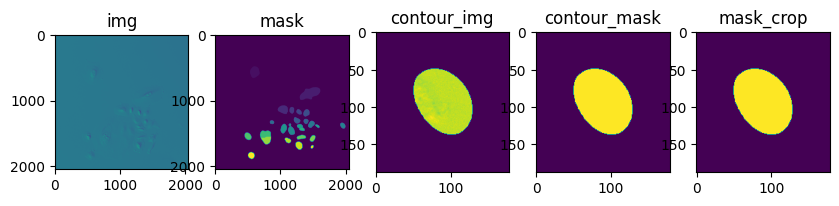

sc time:  6


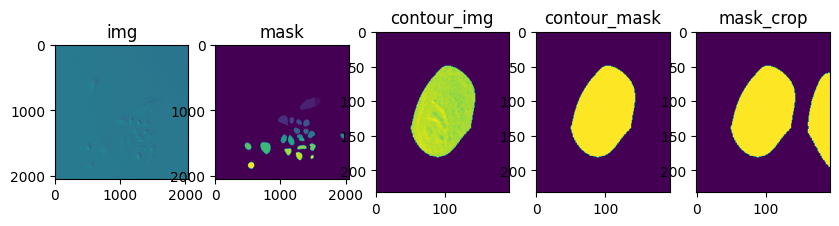

In [18]:
for i, _ in enumerate(single_cells):
    sc = random.sample(single_cells, 1)[0]
    print("sc time: ", sc.timeframe)
    sc.show_panel(padding=50)
    plt.show()
    if i >= 1:
        break

In [19]:
# for testing
# single_cells = single_cells[:10]

In [20]:
single_cells_by_time = {}
for cell in single_cells:
    if cell.timeframe not in single_cells_by_time:
        single_cells_by_time[cell.timeframe] = []
    single_cells_by_time[cell.timeframe].append(cell)

In [21]:
times = sorted(single_cells_by_time.keys())
for time in times[:5]:
    print(time, len(single_cells_by_time[time]))

1 23
2 23
3 25
4 22
5 25


Visualize one single cell

<AxesSubplot: >

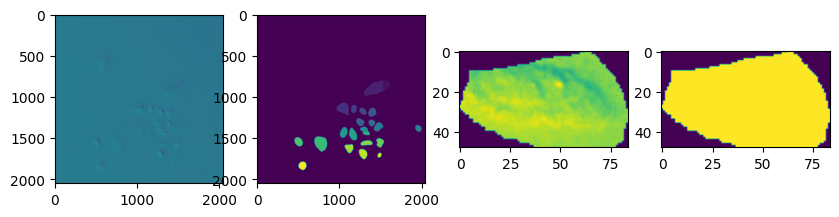

In [22]:
sc = single_cells[0]

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
sc.show(ax=axes[0])
sc.show_mask(ax=axes[1])
sc.show_contour_img(ax=axes[2])
sc.show_contour_mask(ax=axes[3])

In [23]:
from livecell_tracker.segment.utils import match_mask_labels_by_iou
def match_mask_labels_by_iou(seg_label_mask, gt_label_mask, bg_label=0, return_all=False):
    """compute the similarity between ground truth mask and segmentation mask by intersection over union

    Parameters
    ----------
    seg_label_mask : _type_
        _description_
    gt_label_mask : _type_
        _description_
    bg_label : int, optional
        _description_, by default 0
    return_all : bool, optional
        _description_, by default False
    Returns
    -------
        A <gt2seg_map>, mapping ground truth keys to a dictionary of the best matching segmentation label and its iou
    """
    gt2seg_map = {}
    all_gt2seg_iou__map = {}
    # gets all the unique labels in the labeled_seg_mask and gtly_curated_mask
    seg_labels = np.unique(seg_label_mask)
    gt_labels = np.unique(gt_label_mask)

    temp_seg_mask = seg_label_mask.copy()
    temp_gt_mask = gt_label_mask.copy()

    for gt_label in gt_labels:
        if gt_label == bg_label:
            continue
        gt_label_key = gt_label
        all_gt2seg_iou__map[gt_label_key] = []
        gt2seg_map[gt_label_key] = {}
        temp_gt_mask = gt_label_mask.copy()
        # isolates the current cell in the temp gtly_curated_mask and gets its pixels to 1
        temp_gt_mask[temp_gt_mask != gt_label] = 0
        temp_gt_mask[temp_gt_mask != 0] = 1

        best_iou = 0
        for seg_label in seg_labels:
            if seg_label == bg_label:
                continue
            temp_seg_mask = seg_label_mask.copy()

            # isolate the current cell in the temp_seg_mask and set its pixels to 1
            temp_seg_mask[temp_seg_mask != seg_label] = 0
            temp_seg_mask[temp_seg_mask != 0] = 1

            matching_rows, matching_columns = np.where(temp_seg_mask == 1)
            intersection_area = (temp_gt_mask[matching_rows, matching_columns] == 1).sum()
            union_area = temp_gt_mask.sum() + temp_seg_mask.sum() - intersection_area
            iou = intersection_area / union_area
            io_gt = intersection_area / temp_gt_mask.sum()
            io_seg = intersection_area / temp_seg_mask.sum()
            all_gt2seg_iou__map[gt_label_key].append({
                "seg_label": seg_label,
                "iou": iou,
                "io_gt": io_gt,
                "io_seg": io_seg,
            })

            if iou > best_iou:
                best_iou = iou
                gt2seg_map[gt_label_key]["best_iou"] = iou
                gt2seg_map[gt_label_key]["seg_label"] = seg_label
    if return_all:
        return gt2seg_map, all_gt2seg_iou__map
    else:
        return gt2seg_map

In [24]:
sc1 = single_cells_by_time[1][0]
sc2 = single_cells_by_time[2][0]
match_mask_labels_by_iou(sc1.mask_dataset.get_img_by_time(2), sc1.mask_dataset.get_img_by_time(1), return_all=True)

({1: {'best_iou': 0.8934724908902785, 'seg_label': 1},
  2: {'best_iou': 0.914620589656839, 'seg_label': 2},
  3: {'best_iou': 0.9205493196212454, 'seg_label': 3},
  4: {'best_iou': 0.9047822374039283, 'seg_label': 4},
  5: {'best_iou': 0.9364767518009168, 'seg_label': 5},
  6: {'best_iou': 0.8598551575650812, 'seg_label': 6},
  7: {'best_iou': 0.7908130601792573, 'seg_label': 8},
  8: {'best_iou': 0.8765405405405405, 'seg_label': 9},
  9: {'best_iou': 0.8328317030348633, 'seg_label': 10},
  10: {'best_iou': 0.9012568621785612, 'seg_label': 12},
  11: {'best_iou': 0.82194781915953, 'seg_label': 11},
  12: {'best_iou': 0.7156862745098039, 'seg_label': 13},
  13: {'best_iou': 0.8512301678546792, 'seg_label': 14},
  14: {'best_iou': 0.9463049154274038, 'seg_label': 15},
  15: {'best_iou': 0.8793218826678564, 'seg_label': 16},
  16: {'best_iou': 0.6628478586902183, 'seg_label': 17},
  17: {'best_iou': 0.9117292739020918, 'seg_label': 18},
  18: {'best_iou': 0.8917504475967497, 'seg_label':

In [25]:
t1, t2 = 1, 2
mask1 = sc1.mask_dataset.get_img_by_time(t1)
mask2 = sc1.mask_dataset.get_img_by_time(t2)

def compute_match_label_map(t1, t2, mask_dataset, iou_threshold=0.2):
    label_mask1 = mask_dataset.get_img_by_time(t1)
    label_mask2 = mask_dataset.get_img_by_time(t2)

    # Note: first arg is mask2 and second arg is mask1 to create mask1 label to mask2 label map
    # read match_mask_labels_by_iou docstring for more info
    _, score_dict = match_mask_labels_by_iou(label_mask2, label_mask1, return_all=True)
    iou_threshold = 0.2
    label_map = {}
    for label_1 in score_dict:
        label_map[label_1] = {}
        for score_info in score_dict[label_1]:
            if score_info["iou"] > iou_threshold:
                label_map[label_1][score_info["seg_label"]] = {
                    "iou": score_info["iou"]
                }
    return t1, t2, label_map

In [26]:
times = sorted(label_mask_dataset.times)
inputs = []
for idx in range(len(times) - 1):
    t1, t2 = times[idx], times[idx + 1]
    inputs.append((t1, t2, label_mask_dataset))
outputs = parallelize(compute_match_label_map, inputs, None)

100%|██████████| 9/9 [00:32<00:00,  3.58s/it]


Read and load interim results by json

In [27]:
# import json
# map_path = "./notebook_results/multiple_maps.json"
# # read mapping
# with open(map_path, "r") as f:
#     maps = json.load(f)
#     res = []
#     for data_dict in maps:
#         mapping = data_dict["mapping"]
#         tmp_mapping = {}
#         for k, v in mapping.items():
#             tmp_mapping[int(k)] = v
#         mapping = tmp_mapping
#         res.append((int(data_dict["t1"]), int(data_dict["t2"]), int(data_dict["label"]), mapping))

# multiple_maps = res


In [28]:
multiple_maps = []
for t1, t2, label_map in outputs:
    for label in label_map:
        if len(label_map[label]) > 1:
            # print(t1, t2, label, label_map[label])
            multiple_maps.append((t1, t2, label, label_map[label]))

In [29]:
time2id2sc = {}
for sc in single_cells:
    time = sc.timeframe
    if time not in time2id2sc:
        time2id2sc[time] = {}
    assert sc.id not in time2id2sc[time]
    time2id2sc[time][sc.id] = sc

In [30]:
multiple_maps

[(5, 6, 2, {1: {'iou': 0.21701067791176543}, 2: {'iou': 0.687260406103925}}),
 (4,
  5,
  17,
  {17: {'iou': 0.5372909391655946}, 21: {'iou': 0.3713487071977638}}),
 (7,
  8,
  16,
  {16: {'iou': 0.4900331562337714}, 20: {'iou': 0.39316075668223943}}),
 (9, 10, 2, {2: {'iou': 0.5426564759347242}, 3: {'iou': 0.39007280650475634}})]

write multiple_maps json

In [31]:
# json_data = []
# for smap in multiple_maps:
#     data = {
#         "t1": smap[0],
#         "t2": smap[1],
#         "label": int(smap[2]),
#         "mapping": {str(k) : v for k, v in smap[3].items()}
#     }
#     json_data.append(data)

# with open(map_path, "w+") as f:
#     json.dump(json_data, f)

In [32]:
t1, t2, label, mapping = multiple_maps[1]

In [33]:
mapping

{17: {'iou': 0.5372909391655946}, 21: {'iou': 0.3713487071977638}}

In [34]:
# for sc in single_cells_by_time[t1]:
#     print("sc.id", sc.id)
#     print("sc.timeframe", sc.timeframe)
#     sc.show_panel(padding=100)
#     plt.show()

array([<AxesSubplot: title={'center': 'img'}>,
       <AxesSubplot: title={'center': 'mask'}>,
       <AxesSubplot: title={'center': 'contour_img'}>,
       <AxesSubplot: title={'center': 'contour_mask'}>,
       <AxesSubplot: title={'center': 'mask_crop'}>], dtype=object)

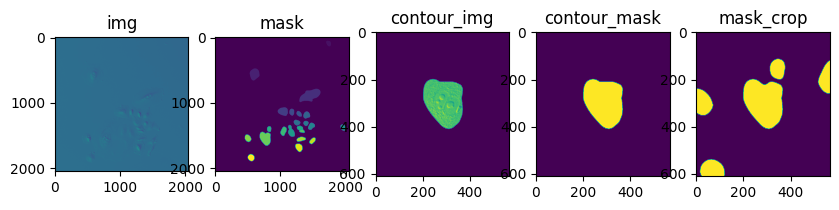

In [35]:
time2id2sc[t1][label].show_panel(padding=200)

5


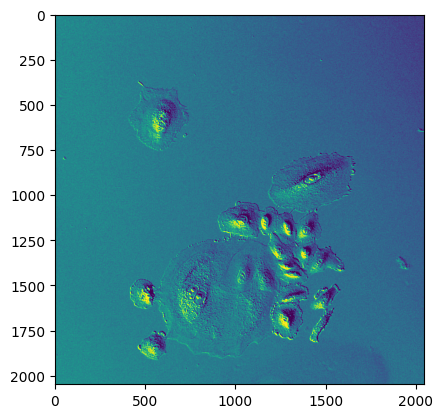

In [38]:
from livecell_tracker.preprocess.utils import enhance_contrast, normalize_img_to_uint8
print(sc.timeframe)

# TODO: add to single cell lib
plt.imshow(enhance_contrast(normalize_img_to_uint8(sc.get_img()), factor=10))

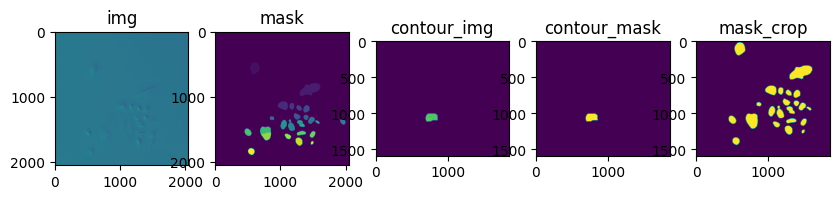

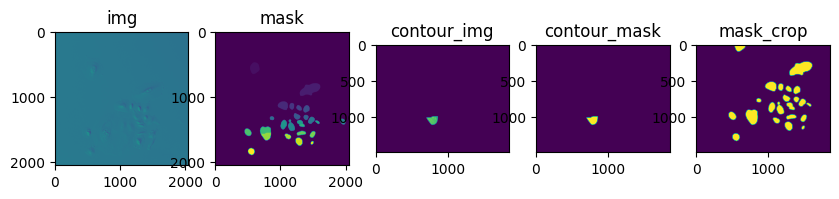

In [37]:
for tmp_label in mapping:
    sc = time2id2sc[t2][tmp_label]
    sc.show_panel(padding=1000)